# Submission for the AIcrowd Blitz Challenge MINILEAVES

Author - Animesh Sinha

Based off template by - Sharada Mohanty

To open the original template on Google Colab, click below!

[![Open Template In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/gist/aicrowd-bot/88e77273624e5dcdc1d52ece742e04a4)


## Comments on the Solution

Convolutional Net solution to detect leaves, some augmentation attempted by adding OpenCV edge detection and color filtering.

The results of again did not work out very well, simpler models have done better on average.

# Initial Setup

## Download data
The first step is to download our train and test datasets. We will be training a classifier on the training dataset and make predictions on test dataset.


In [1]:
#Donwload the datasets
!wget https://s3.eu-central-1.wasabisys.com/aicrowd-practice-challenges/public/minileaves/v0.1/train-images.npy
!wget https://s3.eu-central-1.wasabisys.com/aicrowd-practice-challenges/public/minileaves/v0.1/train-labels.npy
!wget https://s3.eu-central-1.wasabisys.com/aicrowd-practice-challenges/public/minileaves/v0.1/test-images.npy
!wget https://s3.eu-central-1.wasabisys.com/aicrowd-practice-challenges/public/minileaves/v0.1/all_classes.txt

--2020-05-18 18:51:30--  https://s3.eu-central-1.wasabisys.com/aicrowd-practice-challenges/public/minileaves/v0.1/train-images.npy
Resolving s3.eu-central-1.wasabisys.com (s3.eu-central-1.wasabisys.com)... 130.117.252.10, 130.117.252.16, 130.117.252.13, ...
Connecting to s3.eu-central-1.wasabisys.com (s3.eu-central-1.wasabisys.com)|130.117.252.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133527680 (127M) [binary/octet-stream]
Saving to: ‘train-images.npy.1’

train-images.npy.1  100%[===================>] 127.34M  13.5MB/s    in 11s     

2020-05-18 18:51:42 (11.5 MB/s) - ‘train-images.npy.1’ saved [133527680/133527680]

--2020-05-18 18:51:44--  https://s3.eu-central-1.wasabisys.com/aicrowd-practice-challenges/public/minileaves/v0.1/train-labels.npy
Resolving s3.eu-central-1.wasabisys.com (s3.eu-central-1.wasabisys.com)... 130.117.252.10, 130.117.252.16, 130.117.252.13, ...
Connecting to s3.eu-central-1.wasabisys.com (s3.eu-central-1.wasabisys.com)|130.11

## Import packages



In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.metrics import f1_score,precision_score,recall_score,accuracy_score
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import seaborn as sns
import cv2 as cv
from collections import Counter

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Load Data

In [0]:
train_images_path = "train-images.npy" #path where data is stored
train_labels_path = "train-labels.npy"

train_images = np.load(train_images_path)
train_labels = np.load(train_labels_path)

# Load Class mapping
class_names = [x.strip() for x in open("all_classes.txt").readlines()]

# EDA and Data Engineering

Trying to extract features like leaf shape and color.

## Visualize the data

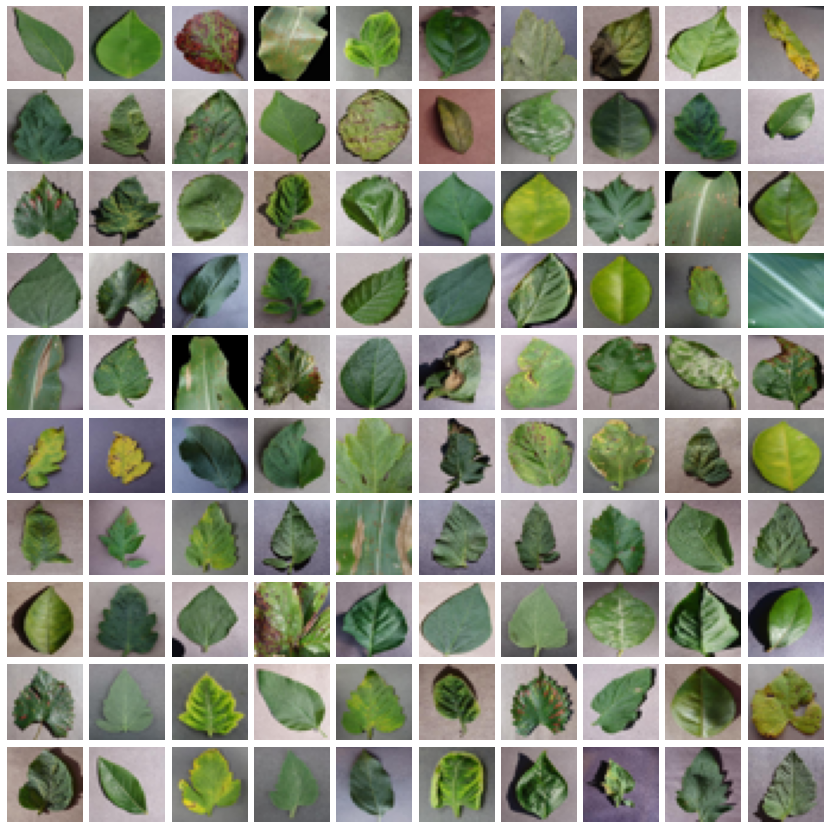

In [4]:
from mpl_toolkits.axes_grid1 import ImageGrid

def random_data_sample():
    """
    Returns a random data sample from the training set
    """
    global class_name, train_images, train_labels
    random_index = np.random.randint(0, train_images.shape[0])
    # Render the image
    image_array = train_images[random_index]
    class_label = train_labels[random_index] # an integral number in [0-38)
    class_name = class_names[class_label] # a human readable class name
    return image_array, class_label, class_name

"""
Render a 7x7 grid of 49 randomly sampled images
from the training set
"""
grid_shape = (10, 10)
fig = plt.figure(figsize=(15, 15))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=grid_shape,  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

data_samples = [random_data_sample() for _ in range(grid_shape[0] * grid_shape[1])]
for ax, data_sample in zip(grid, data_samples):
    image_array, class_label, class_name = data_sample
    ax.imshow(image_array)
    ax.axis('off')

plt.savefig("image-grid.png")

## Preprocessing Images


Mean Color: [74.28693182 82.8125     68.21022727]
Filtered image shape: (32, 32, 1)


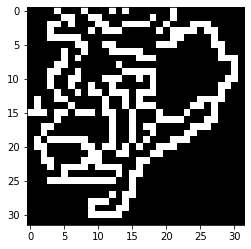

In [5]:
image = train_images[10]
filtered = cv.Canny(image, 100, 200)
mean_color = np.mean(image[5:-5, 8:-8, :], axis=(0, 1))

plt.imshow(filtered, cmap='gray')
print('Mean Color:', mean_color)

filtered = np.reshape(filtered, filtered.shape + (1,))
print('Filtered image shape:', filtered.shape)

[40.47822222 50.55644444 18.85333333]


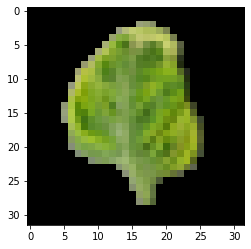

In [6]:
image = train_images[127]
masked = cv.bitwise_and(image, image, mask=cv.inRange(cv.cvtColor(image, cv.COLOR_BGR2HSV), np.array([20, 40, 40]), np.array([255, 255, 255])))
plt.imshow(masked)
print(np.sum(masked, axis=(0, 1)) / np.count_nonzero(masked))

In [0]:
def preprocess_dataset(images):
    edge_shape = (32, 32, 1)

    edges = np.array([np.reshape(
        cv.Canny(image, 100, 200), edge_shape) for image in images])
    masks = np.array([cv.bitwise_and(image, image, mask=cv.inRange(
        cv.cvtColor(image, cv.COLOR_BGR2HSV), np.array([20, 40, 40]), 
        np.array([255, 255, 255]))) for image in images])
    mean = np.array([np.sum(mask, axis=(0, 1)) / 
                     (np.count_nonzero(mask) + 1) for mask in masks])
    return [images, edges, masks, mean]

# Making the DataFrame

## Load data into dataframe 



In [8]:
data_counter = Counter(train_labels)
unique_class_indices = data_counter.keys()
class_count = len(unique_class_indices)
data = []

for _class_index in unique_class_indices:
    data.append([_class_index, class_names[_class_index],  data_counter[_class_index]])

df = pd.DataFrame.from_records(data, columns=["index", "name", "imagecount"], index="index")
df.sort_index(inplace=True)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38 entries, 0 to 37
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   name        38 non-null     object
 1   imagecount  38 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 912.0+ bytes
None


In [9]:
df.head()

,name,imagecount
index,,
0,apple-apple-scab,511
1,apple-black-rot,506
2,apple-cedar-apple-rust,222
3,apple-healthy,1313
4,blueberry-healthy,1205


## Visualizing the Distribution

We may want to fix the distribution of images in different classes from the training set.

        imagecount
count    38.000000
mean   1143.842105
std    1016.930903
min     120.000000
25%     549.750000
50%     874.000000
75%    1301.250000
max    4422.000000


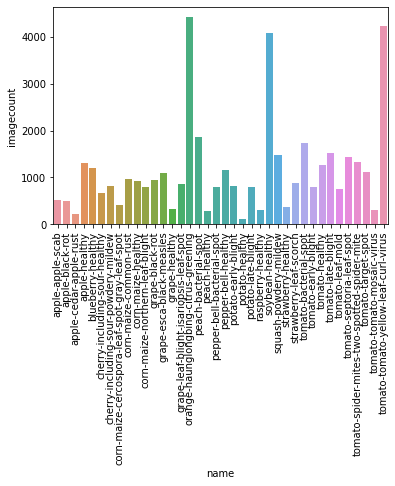

In [10]:
g = sns.barplot(x='name', y='imagecount', data=df)
g.set_xticklabels(g.get_xticklabels(), rotation=90)
print(df.describe())

## Train validation split



In [11]:
RATIO = 0.1

X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=RATIO, shuffle=True)
y_train_labels = y_train.reshape((-1, 1))
y_val_labels = y_val.reshape((-1, 1))
y_train = tf.keras.utils.to_categorical(y_train_labels)
y_val = tf.keras.utils.to_categorical(y_val_labels)

print(pd.Series(y_train.reshape((-1, ))).describe())

count    1.486522e+06
mean     2.631579e-02
std      1.589789e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.000000e+00
dtype: float64


In [12]:
m = X_train.shape[0] # number of samples
print(f"Train data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")
image_shape = X_train[0].shape
print(f"Image shape {image_shape}")

Train data shape: (39119, 32, 32, 3)
Validation data shape: (4347, 32, 32, 3)
Image shape (32, 32, 3)


# Convolutional Neural Nets


## Making the Model

Here we try to use a ResNet / VGG to get the features from the leaves, a simple convolutional net can also be placed instead.

In [0]:
def get_model():
    full_pre = tf.keras.applications.VGG16(include_top=False, weights='imagenet', input_shape=image_shape)
    for layer in full_pre.layers:
        layer.trainable = False
    
    full_net = tf.keras.layers.GlobalAveragePooling2D()(full_pre.output)
    full_net = tf.keras.layers.Flatten(name='ImageFlatten')(full_net)
    full_net = tf.keras.layers.Dense(64, activation='relu', name='ImageDense')(full_net)
    full_net = tf.keras.layers.Dropout(0.1)(full_net)

    input_edges = tf.keras.layers.Input((image_shape[0], image_shape[1], 1), name='EdgeDetectedImageInput')
    edge_net = tf.keras.layers.Conv2D(filters=3, kernel_size=(3, 3), padding="same", activation="relu", name='EdgeConv1')(input_edges)
    edge_net = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), name='EdgePool1')(edge_net)
    edge_net = tf.keras.layers.Conv2D(filters=6, kernel_size=(3, 3), padding="same", activation="relu", name='EdgeConv2')(edge_net)
    edge_net = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), name='EdgePool2')(edge_net)
    edge_net = tf.keras.layers.Flatten(name='EdgeFlatten')(edge_net)
    edge_net = tf.keras.layers.Dense(8, activation='relu', name='EdgeDense')(edge_net)

    input_mask = tf.keras.layers.Input((image_shape[0], image_shape[1], 3), name='MaskDetectedImageInput')
    mask_net = tf.keras.layers.Conv2D(filters=6, kernel_size=(3, 3), padding="same", activation="relu", name='MaskConv1')(input_mask)
    mask_net = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), name='MaskPool1')(mask_net)
    mask_net = tf.keras.layers.Conv2D(filters=12, kernel_size=(3, 3), padding="same", activation="relu", name='MaskConv2')(mask_net)
    mask_net = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), name='MaskPool2')(mask_net)
    mask_net = tf.keras.layers.Conv2D(filters=24, kernel_size=(3, 3), padding="same", activation="relu", name='MaskConv3')(mask_net)
    mask_net = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), name='MaskPool3')(mask_net)
    mask_net = tf.keras.layers.Flatten(name='MaskFlatten')(mask_net)
    mask_net = tf.keras.layers.Dense(8, activation='relu', name='MaskDense')(mask_net)

    input_mean = tf.keras.layers.Input((3,), name='MeanColorInput')
    color_net = tf.keras.layers.Dense(3, activation='relu', name='ColorDense', kernel_regularizer=tf.keras.regularizers.l2(0.02))(input_mean)

    combined = tf.keras.layers.Concatenate(axis=1, name='Catenation')([full_net, edge_net, mask_net, color_net])
    result_class = tf.keras.layers.Dense(class_count, activation='softmax', name='ResultDense')(combined)

    model = tf.keras.models.Model(inputs=[full_pre.inputs, input_edges, input_mask, input_mean], outputs=[result_class])
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["categorical_accuracy"])
    return model

model = get_model()

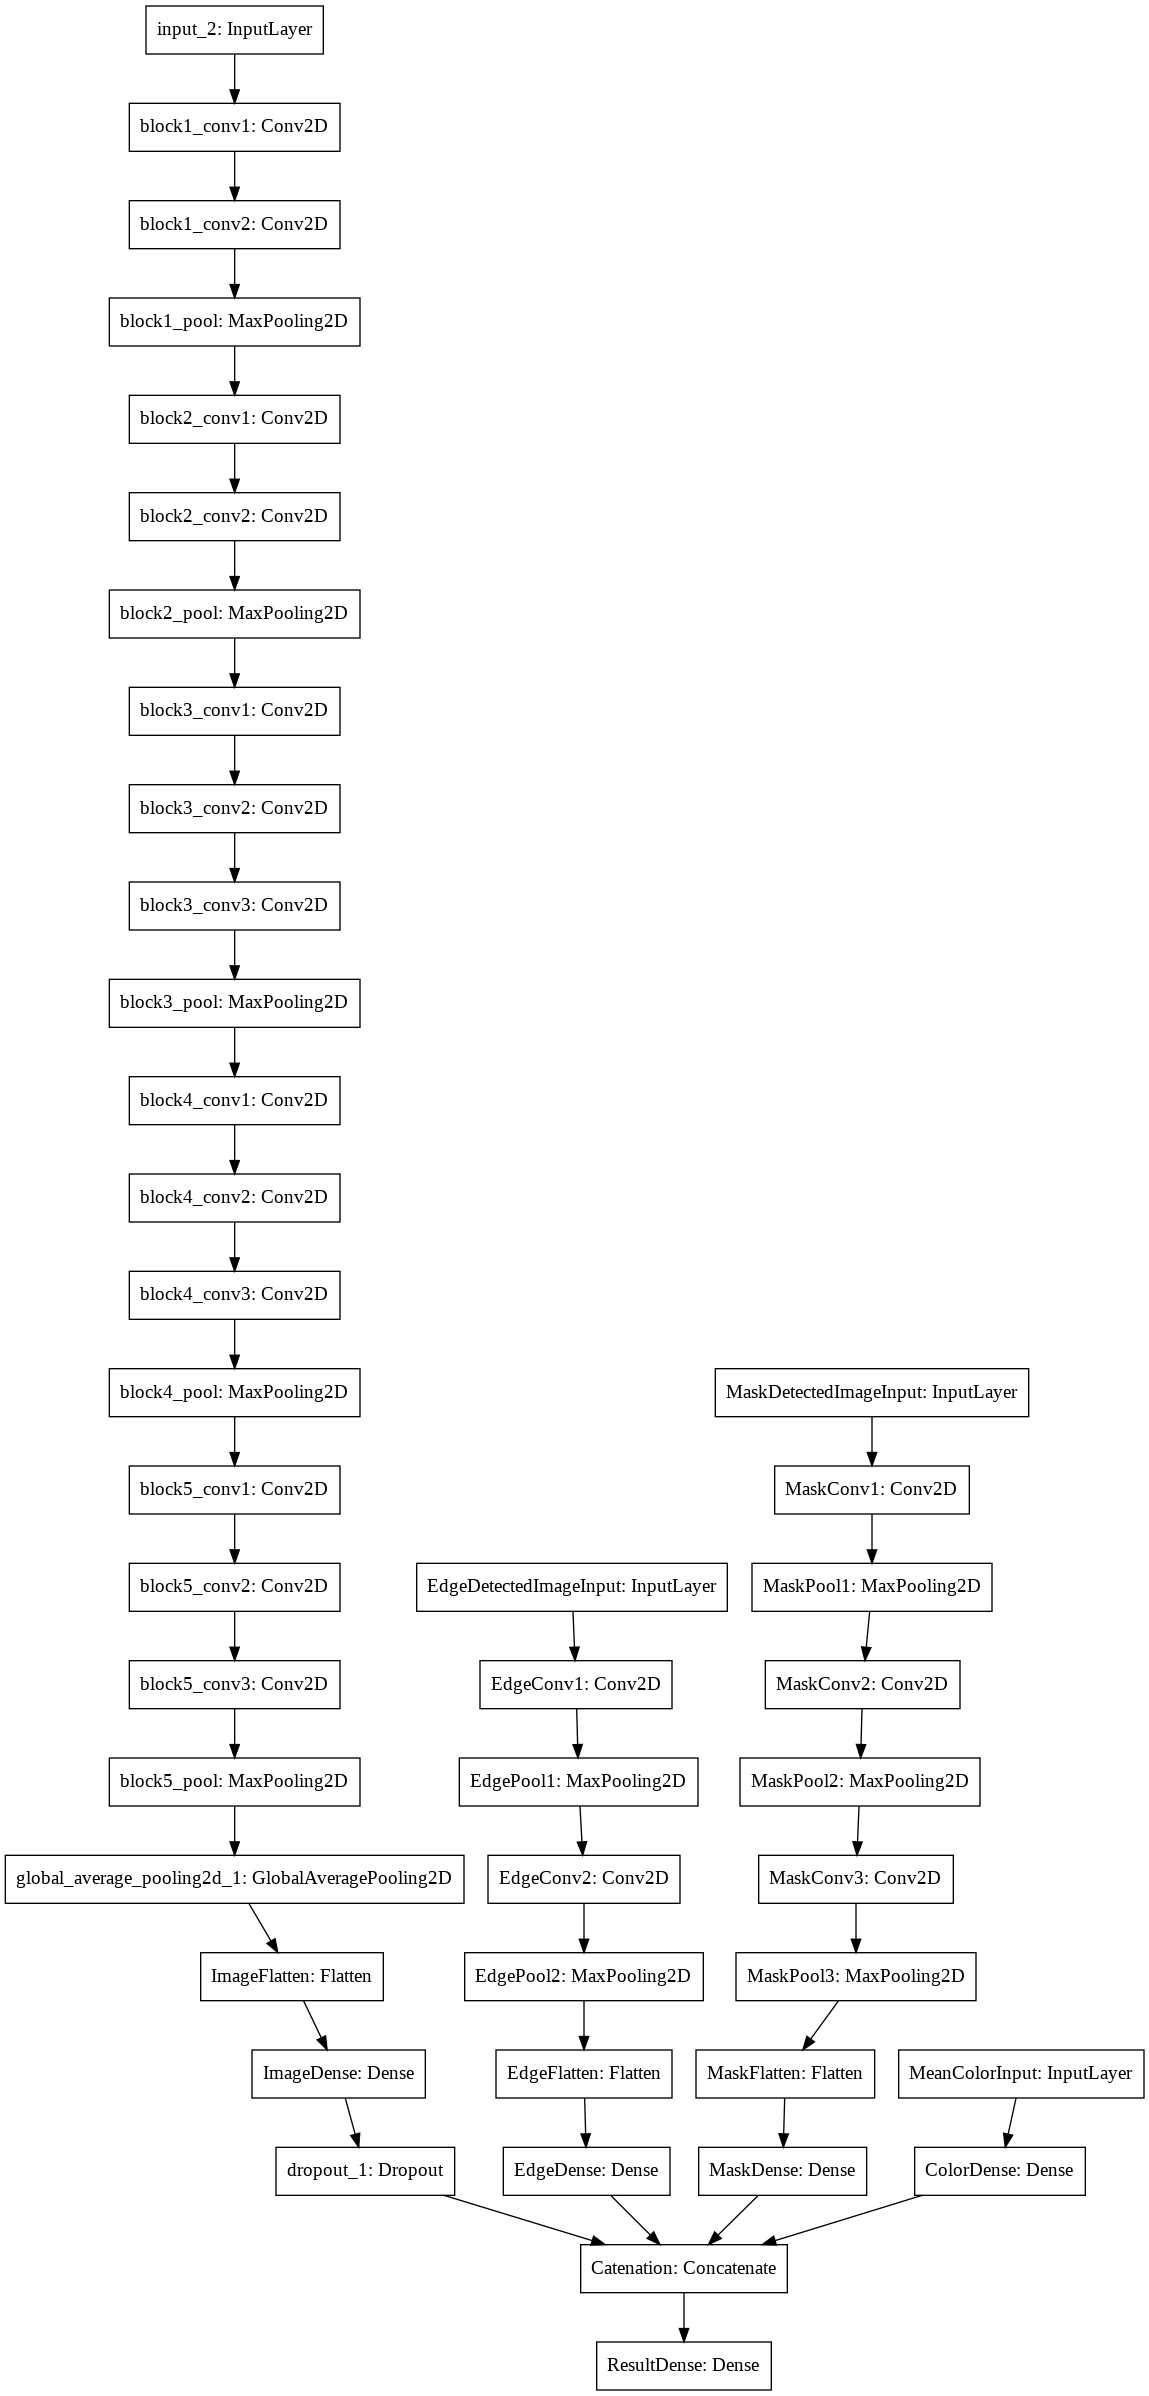

In [15]:
tf.keras.utils.plot_model(model, to_file='model.png')

## Building loss function and stuff


In [16]:
model.fit(
    preprocess_dataset(X_train), y_train,
    validation_data = (preprocess_dataset(X_val), y_val), 
    batch_size = 32,
    epochs = 20,
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_categorical_accuracy', patience=2, factor=0.1, verbose=1)
    ]
)

Epoch 1/20
1223/1223 [==============================] - ETA: 0s - loss: 2.9425 - categorical_accuracy: 0.4837
Epoch 00001: saving model to best_model.h5
1223/1223 [==============================] - 15s 12ms/step - loss: 2.9425 - categorical_accuracy: 0.4837 - val_loss: 1.2581 - val_categorical_accuracy: 0.6499 - lr: 0.0010
Epoch 2/20
1219/1223 [============================>.] - ETA: 0s - loss: 1.1895 - categorical_accuracy: 0.6617
Epoch 00002: saving model to best_model.h5
1223/1223 [==============================] - 14s 11ms/step - loss: 1.1887 - categorical_accuracy: 0.6619 - val_loss: 0.9634 - val_categorical_accuracy: 0.7212 - lr: 0.0010
Epoch 3/20
1219/1223 [============================>.] - ETA: 0s - loss: 0.9657 - categorical_accuracy: 0.7132
Epoch 00003: saving model to best_model.h5
1223/1223 [==============================] - 14s 11ms/step - loss: 0.9650 - categorical_accuracy: 0.7134 - val_loss: 0.8017 - val_categorical_accuracy: 0.7610 - lr: 0.0010
Epoch 4/20
1222/1223 [===

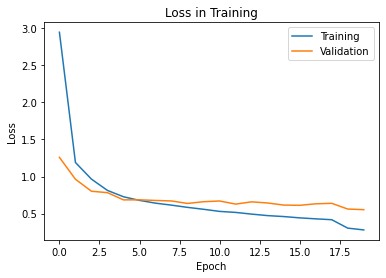

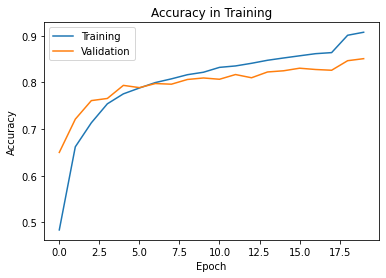

In [17]:
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss in Training')
plt.legend(['Training', 'Validation'])
plt.show()

plt.plot(model.history.history['categorical_accuracy'])
plt.plot(model.history.history['val_categorical_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy in Training')
plt.legend(['Training', 'Validation'])
plt.show()

## Predict on Validation
Now we predict our trained classifier on the validation set and evaluate our model

In [0]:
y_pred = model.predict(preprocess_dataset(X_val), steps=len(X_val))

## Evaluate the Performance
We use the same metrics as that will be used for the test set.  
[F1 score](https://en.wikipedia.org/wiki/F1_score) and [Log Loss](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.log_loss.html) are the metrics for this challenge

In [19]:
prediction = np.argmax(y_pred, axis=1)
print('Precision Score:', precision_score(y_val_labels, prediction, average='micro'))
print('Recall Score:', recall_score(y_val_labels, prediction, average='micro'))
print('Accuracy Score:', accuracy_score(y_val_labels, prediction))
print('F1 Score:', f1_score(y_val_labels, prediction, average='macro'))

Precision Score: 0.8509316770186336
Recall Score: 0.8509316770186336
Accuracy Score: 0.8509316770186336
F1 Score: 0.7917535357192795


(4347,) (4347, 1)


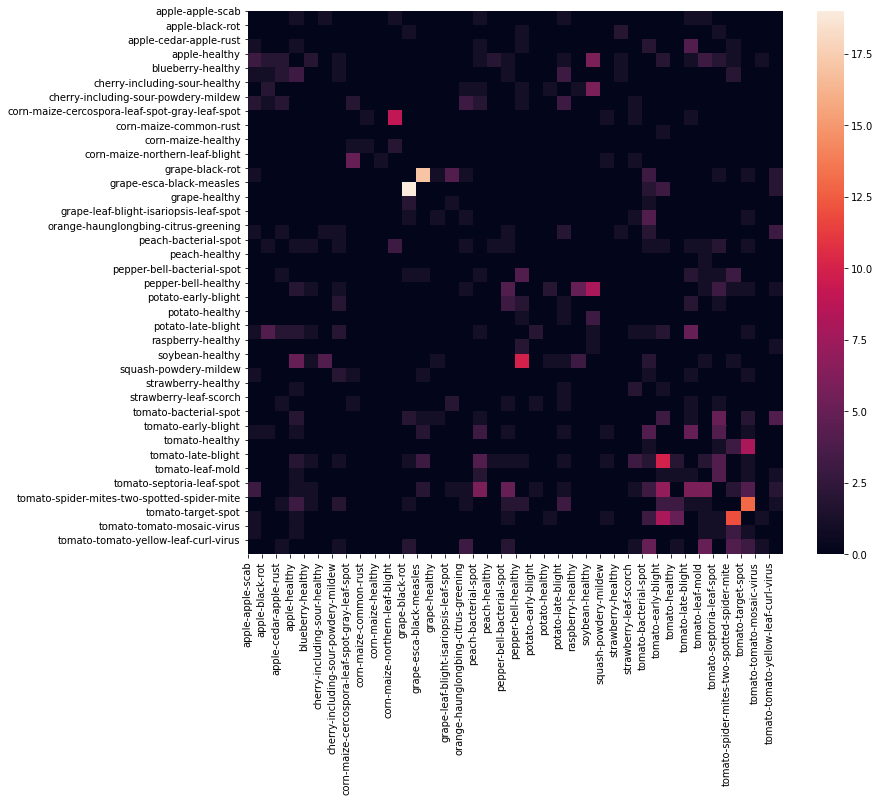

In [20]:
import seaborn as sns

print(prediction.shape, y_val_labels.shape)
test_size = prediction.shape[0]

plt.figure(figsize=(12, 10))
confusion_matrix = np.zeros((class_count, class_count))
for i in range(test_size):
    confusion_matrix[prediction[i]][y_val_labels[i]] += 1 if prediction[i] != y_val_labels[i] else 0
sns.heatmap(confusion_matrix)
plt.yticks(np.arange(len(df.name)), df.name, rotation='horizontal')
plt.xticks(np.arange(len(df.name)), df.name, rotation='vertical')
plt.show()

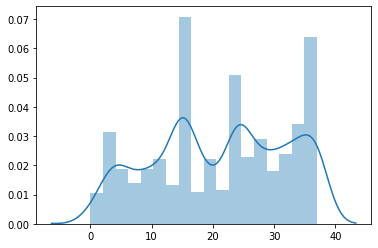

In [21]:
sns.distplot(prediction)

# Prediction on Evaluation Set

## Load Test Set

In [0]:
test_file_path = "test-images.npy"
test_images = np.load(test_file_path)

## Predict Test Set
The moment of truth! Predict on test set and then we can make the submission.

In [23]:
# We first pre-process the test images, the same way we pre-process the train images
submission = model.predict(preprocess_dataset(test_images))
submission = np.argmax(submission, axis=1)
print('Shape:', submission.shape)
print('Submission:', submission)

Shape: (10838,)
Submission: [37 30 35 ... 16 37 24]


## Save the prediction to csv

In [0]:
import pandas as pd
submission = pd.DataFrame(submission)
submission.to_csv('submission.csv',header=['class_index'],index=False)

Note: Do take a look at the submission format.The submission file should contain a header.

## Save it in correct format

To download the generated csv in colab run the below command

In [0]:
# This block is only relevant if you are running this notebook on Google Colab
from google.colab import files
files.download('submission.csv')

Go to [platform](https://www.aicrowd.com/challenges/aicrowd-blitz-may-2020/problems/minileaves). Participate in the challenge and submit the submission.csv.